Questions
* What preprocessing has already been done on the FIX hcp data?
    * What remains to do?
* What are EPI images?
* What is a good atlas/ segmentation scheme?
    * atlas included in HCP dataset?
* Surface vs volume?
* Prediction from connectivity vs decoding?
* When to do group or single subject analysis?
* "Nodes formed local regions or distributed networks? " nodes that are networks to form a network of networks?

Best pipeline choice from https://www.sciencedirect.com/science/article/pii/S1053811919301594
1. brain regions: DictLearn MODL 128 networks
2. connectivity matrices: tangent-space representation
3. classifier: l2-regularized logistic regression (binary)

Connectivity matrices: correlation, partial correlation, tangent space
Brain regions: DictLearn MODL 128 networks, harvard oxford, DiFuMo https://github.com/Parietal-INRIA/DiFuMo

In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
import time
from dypac import Dypac
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

In [8]:
subjects = [108828,180129,114419,118932]
#130316,131722,151223,151526,156637,178950,201111 (have locally but not extracted)
# Define the path to 4D images
paths = []
for sub in subjects:
    paths.append('./HCP_subjects/{}/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii'.format(sub))

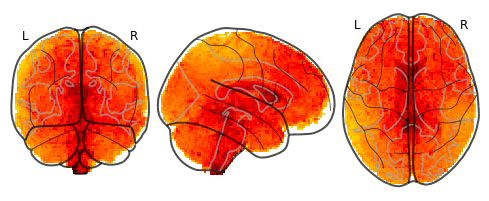

In [12]:
img = image.index_img(paths[0],0)
plotting.plot_glass_brain(img)

# Get Atlases

### Harvard Oxford

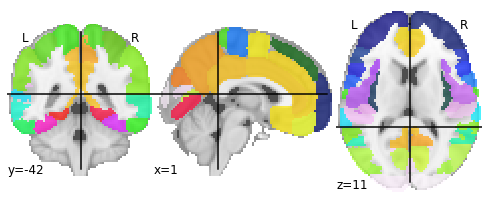

In [18]:
harvard_oxford = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm',symmetric_split=True)
harvard_oxford_filename = harvard_oxford.maps
labels = harvard_oxford.labels

plotting.plot_roi(harvard_oxford_filename)

### DiFuMo

In [26]:
"""Function to fetch DiFuMo atlases.

   Direct download links from OSF:

   dic = {64: https://osf.io/wjum7/download,
          128: https://osf.io/kdfg3/download,
          256: https://osf.io/vza2y/download,
          512: https://osf.io/a23gw/download,
          1024: https://osf.io/jpdum/download,
          }
"""
import os
#import pandas as pd

from sklearn.datasets.base import Bunch

from nilearn.datasets.utils import (_fetch_files,
                                    _get_dataset_dir)


def fetch_difumo(dimension=64, resolution_mm=2, data_dir=None):
    """Fetch DiFuMo brain atlas

    Parameters
    ----------
    dimension : int
        Number of dimensions in the dictionary. Valid resolutions
        available are {64, 128, 256, 512, 1024}.

    resolution_mm : int
        The resolution in mm of the atlas to fetch. Valid options
        available are {2, 3}.

    data_dir : string, optional
        Path where data should be downloaded. By default,
        files are downloaded in home directory.

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :

        - 'maps': str, 4D path to nifti file containing regions definition.
        - 'labels': string list containing the labels of the regions.

    References
    ----------
    Dadi, K., Varoquaux, G., Machlouzarides-Shalit, A., Gorgolewski, KJ.,
    Wassermann, D., Thirion, B., Mensch, A.
    Fine-grain atlases of functional modes for fMRI analysis,
    Paper in preparation
    """
    dic = {64: 'wjum7',
           128: 'kdfg3',
           256: 'vza2y',
           512: 'a23gw',
           1024: 'jpdum',
           }
    valid_dimensions = [64, 128, 256, 512, 1024]
    valid_resolution_mm = [2, 3]
    if dimension not in valid_dimensions:
        raise ValueError("Requested dimension={} is not available. Valid "
                         "options: {}".format(dimension, valid_dimensions))
    if resolution_mm not in valid_resolution_mm:
        raise ValueError("Requested resolution_mm={} is not available. Valid "
                         "options: {}".format(resolution_mm,
                                              valid_resolution_mm))
    url = 'https://osf.io/{}/download'.format(dic[dimension])
    opts = {'uncompress': True}

    csv_file = os.path.join('{0}', 'labels_{0}_dictionary.csv')
    if resolution_mm != 3:
        nifti_file = os.path.join('{0}', 'maps.nii.gz')
    else:
        nifti_file = os.path.join('{0}', '3mm', 'resampled_maps.nii.gz')

    files = [(csv_file.format(dimension), url, opts),
             (nifti_file.format(dimension), url, opts)]

    dataset_name = 'difumo_atlases'

    data_dir = _get_dataset_dir(data_dir=None, dataset_name=dataset_name,
                                verbose=1)

    # Download the zip file, first
    files = _fetch_files(data_dir, files, verbose=2)
    labels = pd.read_csv(files[0])

    # README
    readme_files = [('README.md', 'https://osf.io/u5xhn/download',
                    {'move': 'README.md'})]
    if not os.path.exists(os.path.join(data_dir, 'README.md')):
        _fetch_files(data_dir, readme_files, verbose=2)

    # Python resampling script
    script_files = [('resample_dictionaries.py', 'https://osf.io/ezr37/download',
                    {'move': 'resample_dictionaries.py'})]
    if not os.path.exists(os.path.join(data_dir, 'resample_dictionaries.py')):
        _fetch_files(data_dir, script_files, verbose=2)

    return Bunch(maps=files[1], labels=labels)

In [27]:
maps_img = fetch_difumo(dimension=64).maps


Dataset created in /home/annabelle/nilearn_data/difumo_atlases



Downloaded 1243510 of 1243510 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/annabelle/nilearn_data/difumo_atlases/a05611eaa8d2b0e4b16b506ce85840af/download..... done.


Downloaded 2749 of 2749 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 769 of 769 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


# Load image into time series
https://nilearn.github.io/user_guide.html

In [13]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)
time_series1 = masker.fit_transform(path1)
time_series2 = masker.fit_transform(path2)

[NiftiLabelsMasker.fit_transform] loading data from /home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from /home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/annabelle/Documents/brainhack/harveyaa_fMRI_neuroticism/10_subject_HCP/114419/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/home/annabelle/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,

# Produce connectivity matrices

* correlation
* tangent space embedding

In [14]:
correlation_measure = ConnectivityMeasure(kind = 'correlation')
correlation_matrix1 = correlation_measure.fit_transform([time_series1])[0]
correlation_matrix2 = correlation_measure.fit_transform([time_series2])[0]

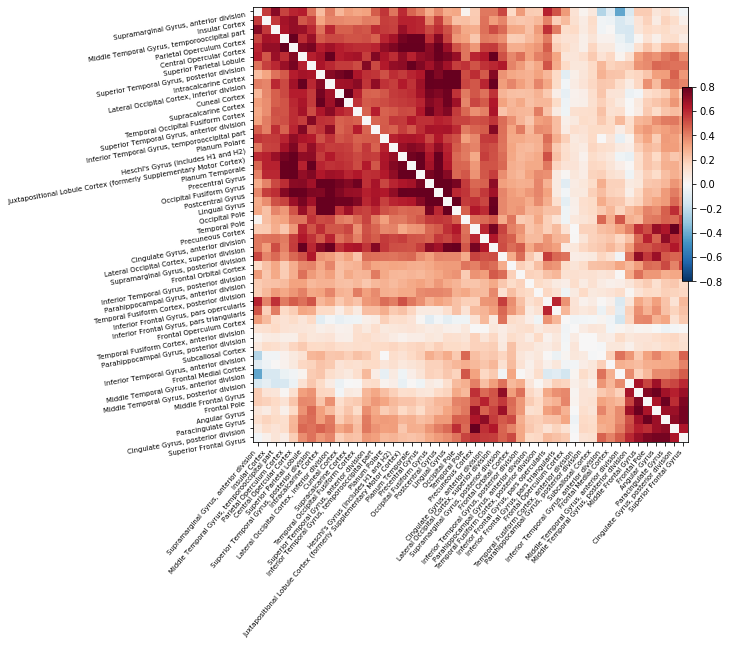

In [12]:
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix1, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix1, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

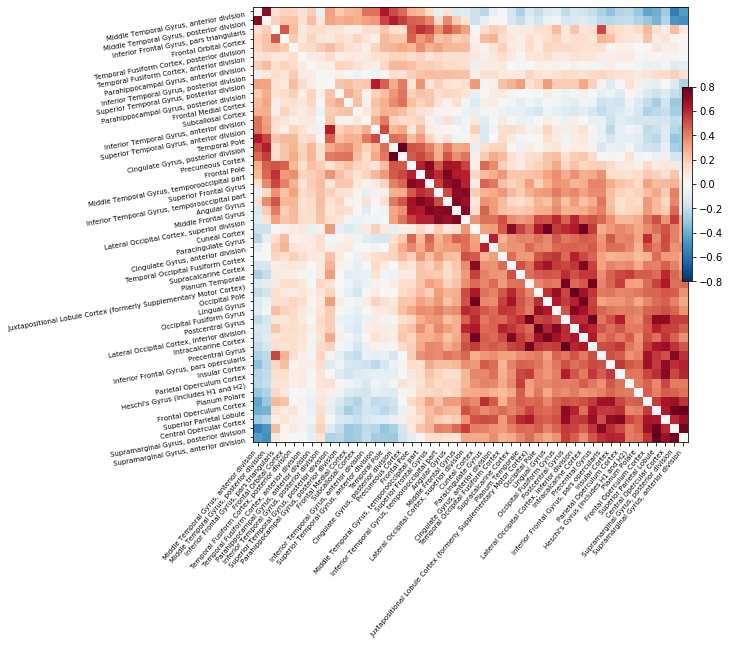

In [15]:
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix2, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix2, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

# Explore different approaches

### Dypac / dynamic states of parcellation
https://www.biorxiv.org/content/10.1101/2020.03.02.972760v1.full

Absolutely no way this is going to run locally

In [1]:
#img_section = image.load_img(path1, slice(0,5))
#model = Dypac(n_clusters=10, n_states=20, verbose=1, n_init=1, n_init_aggregation=1, n_replications=20, 
#              detrend=True, smoothing_fwhm=5, standardize=True, n_batch=2, threshold_sim=0)
#model.fit(img_section)

### Dynamic mode decomposition
https://www.frontiersin.org/articles/10.3389/fncom.2019.00075/full

https://github.com/kunert/DMD_RSN

# Similarity network fusion
https://www.biorxiv.org/content/10.1101/2020.03.05.979526v1
* combine different characterizations of connectivity matrices with SNF?